# Iterative Text Analysis with Yelp Review Data
## By: Peter Grange

#### Code: https://github.com/petergrange/IterativeNLP

#### Project Overview

**Goal:** I want to understand what aspects of customers’ experiences inform how they rate business.

**Motivation:** I want to explore how topic modeling works with text data

**Approach:**  My analysis is an unsupervised learning problem topic-modelling Yelp Review data with a goal of extracting themes that lead to high or low star ratings. I will specifically be looking at reviews of pizza places.

## Modeling: An Iterative Approach
<ol>
<li> Basic Summary of Data
<li>Term Frequency - Inverse Document Frequency (tf-idf): create bag-of-words and weight important words
<li>K-Means: cluster review categories at a high level, business category and restaurant type
<li>Latent Dirichlet Allocation (LDA): models topics to confirm the effectiveness of the K-Means Clustering
<li>Bucket by Star Rating: gain insights based off of words and word combinations that appear in different rating categories
<li> Another tf-idf: remove category specific words
<li> Another LDA : model topics to hone in on key ideas and key word combinations within a cluster
<li> Recommendations to Businesses
</ol>

#### A Cool Technical Insight:
The key technical insight is that an iterative application of NLP techniques reveals progressively deeper themes in the textual data. The first pass of tf-idf and K-Means produces high level themes (in this case, business category and restaurant type) while the subsequent pass of tf-idf and LDA hone in on lower level themes (in this case, key ideas or business features that lead to high or low reviews).

This iterative approach, while applied here to business review data, could be used with all sorts of NLP data. Any situation where honing in on different thematic strata within text data is needed.

## Imports and Basic Set Up

In [1]:
# Imports - Basic and Visualization Packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import for logging
from time import time

In [3]:
# Imports - scikit-learn Vector Space Modeling Packages

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

In [4]:
# Imports - Gensim Vector Space Modeling Packages

from gensim.models.ldamodel import LdaModel
from gensim.matutils import Sparse2Corpus

# For Speeding up Gensim
import cython

## 1. The Business Problem

There is a plethora of business questions that business owners have. The problem is how to answer those questions with the available data.

There are some questions that every business has, particularly small, service-oriented businesses, like restaurants. What do my customers think about my business? My service? My quality? What do my customers care about? What gives them a positive or negative experience? What are they telling others about my business? How do I compare to my competitors? Etc.

For a long time, these questions were hard to answer. You had to ask customers, create surveys, read isolated blogs, etc. But now with sites like Yelp, tons of relevant data is at business owners finger tips. Unfortunately, this data may not be organized to show what are common themes in customer reviews. The data does not initially allow you to compare your business to other similar business. In short, it takes work to turn the wealth of data into actionable information.

In this project, I seek to use Natural Language Processing (NLP) techniques to hone in on relevant business categories and pertinent topics to elucidate customers thoughts on specific business categories, to show what makes customers happy or unhappy enough to write reviews and share their thoughts.

## 2. The Data Set
Yelp provides a large, clean data set with over 2.5M reviews. The data set is available here: https://www.yelp.com/dataset_challenge. This freed me up to focus right on analysis instead of having to work to compile a data set through web scraping.

In [5]:
# Importing Data Set: available at https://www.yelp.com/dataset_challenge
t0 = time()
yrev = pd.read_csv('yelp_review.csv', sep=',')
print("done in %0.3fs." % (time() - t0))

done in 56.792s.


In [6]:
# Examining the Basic Features of the 2.6M record Data Set; I'm examining "tail" instead of "head" to confirm the number or records.
yrev.tail(2)

,business_id,date,review_id,stars,text,type,user_id,votes_cool,votes_funny,votes_useful
2685065,DH2Ujt_hwcMBIz8VvCb0Lg,2016-04-30,vwmqHxxmy9rEAwhbkLXmnQ,3,"He stood in the face of a 2.5 star biz, and br...",review,nELVJlkX8T0mUAArSPSJxw,4.0,5.0,4.0
2685066,DH2Ujt_hwcMBIz8VvCb0Lg,2016-07-11,DDmiTM_jMhshjYkXk5Sshg,1,2 pm Monday afternoon. Out of sour cream (ridi...,review,maAimqEE4G483rtifPKlYg,0.0,0.0,0.0


### Data Dictionary
Here are the features (columns) of the Yelp Review Data Set:

Variable | Description | Type of Variable
---| ---| ---
Business_ID | An ID unique to each business | Alpha-Numeric - Continuous
Date | Date of review | Date - Continuous 
Review_ID | A unique ID of each review, Table Primary Key | Alpha-Numeric - Continuous
Stars | The star rating assigned by the user to the business, ranging from integers 1 through 5 | Numerical - Continuous
Text | Free-form user inputed text reviewing the business | Textual 
User_ID | An ID unique to each user | Alpha-Numeric - Continuous
Votes_Cool | A count-number of the "cool" upvotes of a particular review | Numerical - Continuous
Votes_Funny | A count-number of the "funny" upvotes of a particular review | Numerical - Continuous
Votes_Useful | A count-number of the "useful" upvotes of a particular review | Numerical - Continuous

I will only be looking at Stars and Text columns since I want to understand what leads users to reviews businesses high or low.

**Expansion:** If I were a specific business, I could hone in on Business_ID. If I wanted to understand user reviewing habits, I would look at User_ID. It would be facinating to explore if there are common elements in reviews that get upvoted as "useful." The data set contains tons of material for analysis.

### Basic Statistic of the Data Set

In [7]:
print "There are..."
print "\t", yrev.business_id.nunique(), "different business being reviewed"
print "\t", yrev.review_id.nunique(), "total reviews (this is the number of records in the data set)"
print "\t", yrev.user_id.nunique(), "different users reviewing business"
print "\t", yrev.votes_cool.sum(), "total 'votes_cool' upvotes"
print "\t", yrev.votes_funny.sum(), "total 'votes_funny' upvotes"
print "\t", yrev.votes_useful.sum(), "total 'votes_useful' upvotes"

There are...
	85540 different business being reviewed
	2685067 total reviews (this is the number of records in the data set)
	686556 different users reviewing business
	1447187.0 total 'votes_cool' upvotes
	1157422.0 total 'votes_funny' upvotes
	2703358.0 total 'votes_useful' upvotes


### Summary of Star Data

The simple bar chart shows that there are more higher reviews than lower reviews. There are actually more 5 star reviews than 1, 2, and 3 star reviews put together.

The average star rating across all reviews is 3.76


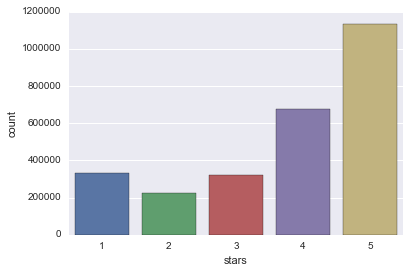

In [8]:
sns.countplot(x='stars', data = yrev) # ADD FEQUENCY PRESENTAGES
print "The average star rating across all reviews is", round(yrev.stars.mean(), 2)

### Bias in the data!?!?!
There are two main ways that the data is biased, or not fully representative of the population.

1. This is only data of people who use yelp and who review on yelp. With the exception of serial reviewers, reviews often come from very happy or more often very unhappy customers, which naturally skews the data. That said, it does show what people care enough about to bother reviewing for. So it tends to show the issues that customers get motivated over.
2. Yelp describes the data set as "includes information about local businesses in 10 cities across 4 countries." So while this is a good representation and enough to train a model off of, it is not a complete representation. Also, if we want insights, say, into the market in the USA or in rural areas, there will be skew based off of the data set.

### Cleaning up the data set

I am cleaning up the data set by dropping any rows that have missing values (there was only one or two) and by limiting the data to columns that are pertinent to my analysis, which are the stars and text columns. I am creating an abridged data frame mostly to speed up performance by avoiding unnecessary data.

In [9]:
# Cleaning up data by dropping missing values and limiting columns only to the relavent ones

data = yrev[['stars', 'text']].dropna() #dropping missing values and renaming cleaned dataset
data.head(2) # Examining the top two lines of quaried data set

,stars,text
0,4,"Mr Hoagie is an institution. Walking in, it do..."
1,5,Excellent food. Superb customer service. I mis...


## 3. Analysis

### Category Clustering: Business Type & Restaurant Type

There are three problems. 
1. There is too much data. My computer cannot handle 2.5M records, even with only 2 columns.
2. The main column ('text') has no structured category markers. It is not organized by business type (Restaurants, Car Shops, Hair Salons, etc.)
3. The main column ('text') is not structured by type of restaurants (pizza places, sandwich shops, asain, italian, etc.) 

So I need to limit the size of the data being explored and then explore the data using NLP models to hone in on the specific category I am interested in, which in this case is pizza places.

#### Setting up key variables

In [10]:
n_samples = 10000 #number of samples
n_features = 2000 #number of features
n_topics = 10 #number of topics
n_top_words = 20 #number of top words

#### Initial Vectorization and Weighting-Transformation (term frequency - inverse document frequency)
Before I do any analysis, I need to convert the review data, which is stuctured as English sentances into a number vector that can be analyized by the computer. I will be doing a two step process in one step. 
1. The first step is to create a count vector, also called 'bag-of-words'. This count vector is simply a count of how many times a word from our dictionary (feature) shows up in particular sentance (row or sample). We could stop here with a count vector. This is enough to run a model on. But the issue with the count vector is that it will prioritize common words which may hinder our ability to generalize from the data.

2. So the second step, to avoid this issue, is to weight the the term frequency, represented in the count vector, by the inverse of the document frequency. Essentially, while term frequency assumes that more frequent terms are generally more telling for what a review is about, document frequency adds that if a term is in more documents, then it is probably less important for telling key information than a word that is in less documents.

This two step vectorization and transformation is called term frequency - inverse document frequency transformation or tfidf.

In [11]:
# Use tf-idf features for Category Clustering for Business Type.
print("Extracting tf-idf features for Category Clustering...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5,
                                   max_features=n_features,
                                   stop_words='english',
                                   ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(data[:n_samples]['text'])

Extracting tf-idf features for Category Clustering...


A few notes on the tf-idf transformation. 
1. I excluded common "stop words," which are common parts of speech that do not tell much about what is really being talked about (these are things like articles (a, an, the), prepositions (of, for, by, etc.), conjunctions (and, but, which, etc.), pronouns (I, you, we, them, etc.), etc.)
2. I am examining 10000 samples. This will function as a training set (one used to set up a model), as well as ensuring that I do not crash my computer with all 2.6M samples.
3. I exclude words that are in 95% of the documents. The assumption is that if a word shows up in more than 95% of the documents it does not give us much insight about the documents is about. Essentially, words that show up in most document are probably filler words, the ones necessary to move from key idea to key idea, while words that show up in less documents are probably the key ideas that actually show what the document is about.
3. I excluded words whose count frequency was less than 5. If a word does not show up 5 times in 10000 reviews, than I am concluding that it is not very telling for my analysis. Plus at this point, I want to hone in on over arching terms to form a good cluster around categories.
4. I am examining 2000 features, that is my dictionary will only include the 2000 most common feature (single word or 2-gram; see next list item).
5. I am looking at both single words and two word combination (a 2-gram).

### Clustering with K-Means

Now that I have created a weighted number vector, I want to see how these number vectors cluster around each other, with the assumption being that if they cluster in vector space; they should cluster in topical, semantical, or categorical as well. To do this, I will use the K-Means clustering algorithm. K-Means starts with random cluster centers and then assigns all of the samples to the cluster they are closest to. Then it re-adjusts the cluster center based off of the samples now assigned to the cluster. Then it re-assigns the samples to the new cluster center that it is now closest to. It continues to do this until there is no change between iterations in which samples are assigned to which cluster center.

In [12]:
# Creating Category Clusters on the tf-idf vectors with K-Means
kmeansF = KMeans(n_clusters=n_topics, random_state=0, n_jobs=2).fit(tfidf)

#### Adding the K-Means cluster number back to the data set

I am adding the K-Means cluster number back to the corresponding row (sample) so that I can analysis the data grouped by cluster. I will need to check over the clusters to make sure that K-Means actually worked as expected.

In [13]:
# Creating a new data frame with only the first 10K rows and adding in the cluster IDs
labeled = data[:kmeansF.labels_.size]
labeled['cluster ID'] = kmeansF.labels_
labeled.head(2)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,stars,text,cluster ID
0,4,"Mr Hoagie is an institution. Walking in, it do...",4
1,5,Excellent food. Superb customer service. I mis...,4


Looking at the distribution of the star rating, shows that this sample of the data is close but not perfectly reprsentative of the data. In the full data set, there are more 1 star reviews than 3 star reviews. Also, the mean star rating in the original is 3.76, while it is 3.61 in this new set. Even still, the distribution looks close.

Mean star rating for this subset of data is 3.61


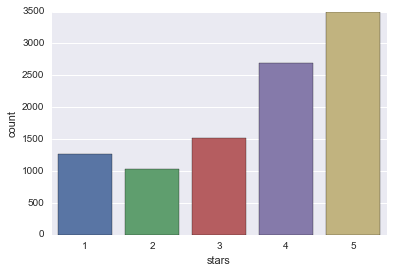

In [14]:
sns.countplot(x='stars', data = labeled)
print "Mean star rating for this subset of data is", round(labeled.stars.mean(), 2)

### Bucketing Reviews by Cluster ID

Since my goal is to a hone in on a specific business category, in this case I have chosen pizza places, I need to bracket the reviews by cluster ID and examine each cluster to see what it appears to be clustering on. I can visually examine a sample of each cluster...time consuming and risks being skewed by an inaccurate sample representation.

In [15]:
# Grouping data by cluster ID column...ending with 10 groups
clusters = labeled.groupby(['cluster ID'])

# Creating seperate data frames for each cluster group
clust0 = clusters.get_group(0)['text']
clust1 = clusters.get_group(1)['text']
clust2 = clusters.get_group(2)['text']
clust3 = clusters.get_group(3)['text']
clust4 = clusters.get_group(4)['text']
clust5 = clusters.get_group(5)['text']
clust6 = clusters.get_group(6)['text']
clust7 = clusters.get_group(7)['text']
clust8 = clusters.get_group(8)['text']
clust9 = clusters.get_group(9)['text']

### Cluster Identification: Visually
I will identify each cluster by visually inspecting the first 50 rows. And then label them based on what I appears to be the central theme.

This next cell prints the top 50 reviews of each cluster (This number can be set by setting the 'num' variable in the prt function. Each needs to be visually examined to identify the theme of the cluster. The clusters can then be labelled and the pertinent cluster(s) selected. In this case, the pizza related themes clustered nicely in cluster #1.

In [16]:
"""
Uncomment out the code below if you have any interest in examine each category.
Code for category #0 and #1 is in the cells below.
I have summarized the 10 categories below as well.
The fuction directly below, prints out the text review (limited to the first 200 characters, delete the [:200] to print them in their entirety) for the first 50 reviews (you can pick less by setting num = to whatever number you'd like).
"""
def prt(x, num = 50):
    for i in x[:num]:
        print "\n", i[:200],

#for X in xrange(0, 10):
#    y = 'print clust%d.head(50)' %(X)
#    z =  'print prt(clust%d, num = 50)' %(X)
#    print "Printing Cluster #%d" %(X)
#    exec(y)
#    exec(z)
#    print "\n"

####  Business Category Cluster Summary:
My goal is to hone in only on Topic Clusters that focusing on pizza oriented business's within the Food industry.

Here is a summary of what each topic seemed to be focusing on.

6. Category #0: Hair Salons
3. ***Category #1: Restaurants / Pizza / Italian***
5. Category #2: Misc 
7. Category #3: Restaurants / Bar / Beer / Positive
2. Category #4: Restaurants / Positive / Bar / Breakfast "Kings Family Restuarant"
4. Category #5: Ice Cream
10. Category #6: Grocery / Convenience / Craft Stores / Starbucks (?)
8. Category #7: Restaurants / Sushi
9. Category #8: Restaurants / Sandwich Shop / Fish / Mixed Reviews
1. Category #9: Auto Mechanics / Auto Parts / Vets / Contractors / Driving Range

***So I will only be examining topic #1***

***Important Note*** If someone runs the above techniques, but changes some of the parameters, the cluster categories may change order. Although the breakdown of topics within the categories would likely stay very close, the order of the categories would likely change.

#### Examining Cluster #0 and #1

Below I demonstate what the visual inspection process is like. It can be tedious, but often a them jumps out at you. I cluster #0 words like hair, cut, salon, updo, etc. are almost always in the first line of the review. For cluster #1 words like pizza, cheese, chrust, etc. are in the first usually in the lines if the review. I will limit the number printed to save space, but I would examine about 50 reviews, if I were going to try to identify the clusters visually.

In [17]:
print "Here is Cluster #0, which I've identified as 'Hair Salons'"
print clust0.head(10)
print "\n", prt(clust0, num = 10),

Here is Cluster #0, which I've identified as 'Hair Salons'
1735    Now I'm picky about my hair, but Mane Attracti...
1736    I have been getting my hair cut and hi-lighted...
1737    Let me just tell you, I have really, really di...
1892    My Kingston cooper is a havanese and is a goof...
1959    Can't recommend this barber highly enough.  I ...
2009    Nothing spectacular, but I go there regularly,...
2010    i'm not sure why this place has bad reviews. i...
2012    Went here with a friend for his haircut. It's ...
2013    I went there today! The cut was terrible! I ha...
2014    I used to cut my own hair, haphazardly, with a...
Name: text, dtype: object


Now I'm picky about my hair, but Mane Attractions was so bad that I walked out after about 15 minutes of watching the stylists work on other clients.

I had desperately needed a haircut and walked in  
I have been getting my hair cut and hi-lighted at Mane Attractions for over 5 years, by Sue, the owner. I am always extremely happy

In [18]:
print "\nHere is Cluster #1, which I've identified as 'Restaurants / Pizza / Italian'"
print clust1.head(10) # this is the pizza cluster
print prt(clust1, num = 10)


Here is Cluster #1, which I've identified as 'Restaurants / Pizza / Italian'
3      PROS: Italian hoagie was delicious.  Friendly ...
45     This would be my local haunt, if I were ever t...
212    Recommended. 16 inch pizza on special was chea...
213    Some of the worst pizza I've ever had.  We use...
265    Papa J's is by far my favorite restaurant in P...
271    I went there for dinner last night with a clie...
272    What a wonderful surprise found in Carnegie PA...
273    Yay, I'm a fan but sometimes service is a litt...
275    Yay, I'm a fan of the white pizza.  Had take o...
276    We met our good friends from Morgantown here f...
Name: text, dtype: object

PROS: Italian hoagie was delicious.  Friendly counter employee. The restaurant was clean and neat. 

CONS: The pizza was not good.  Pre-formed crust, NOT fresh dough.  The price of the failure of a pi 
This would be my local haunt, if I were ever to relocate to the Pittsburgh area. What a great little place! Such friendly s

#### Problem with Visually Identifying Clusters

A primary problem with identifying the clusters visually is the tedious nature of the work, and the limitation of only really being able to focus on the 25 to 50 rows, even that number can be pretty time consuming and any less is not a sufficent representation. I can also use LDA to either confirm cluster identity or to actually identify the clusters.

### Cluster Identification: LDA

A clear advantage of using LDA to identify the clusters is that it will take into account all pertinent samples instead of just 25 to 50. It also is much quicker when trying to identify many clusters.

Below I will demonstrate this on Cluster #1 since I am honing in an pizza places.

I am creating a Count Vector without inverse weighting for terms in most document (I'm not using the "idf" weighting), since I want to see the terms that permeate the documents to confirm that the clustering worked.

In [19]:
#Only consider at max 1000 features (words in our vocab)
vectorizer = CountVectorizer(max_features = n_features, 
                             stop_words='english',
                             min_df=3,
                             ngram_range=(1, 2))

In [20]:
### Fit and Transform in 1 step
### `fit` learns the vocabulary of the reviews
### Use `tranform` to generate the sample X word matrix - one column per feature (word or n-grams)
C1_matrix = vectorizer.fit_transform(clust1)

# Creating a dictionary of word IDs to words  which is an input in the LDA model
id2word = dict(enumerate(vectorizer.get_feature_names()))

# Converting the word-matrix into gensim's format corpus
corpusC1 = Sparse2Corpus(C1_matrix, documents_columns = False)

# Fitting an Latent Dirichlet Allocation model with Cluster 2 and all Star Levels
lda_model = LdaModel(corpus=corpusC1, id2word=id2word, num_topics=n_topics)

In [21]:
num_topics = 5
n_words_per_topic = 9
for ti, topic in enumerate(lda_model.show_topics(num_topics = num_topics, num_words= n_words_per_topic)):
    print("Topic: %d" % (ti)), (topic)

Topic: 0 (8, u'0.056*pizza + 0.025*good + 0.017*place + 0.010*crust + 0.010*cheese + 0.008*ordered + 0.007*sauce + 0.007*just + 0.006*great')
Topic: 1 (6, u'0.058*pizza + 0.027*good + 0.011*cheese + 0.009*crust + 0.009*place + 0.009*really + 0.008*like + 0.007*just + 0.007*time')
Topic: 2 (9, u'0.071*pizza + 0.014*place + 0.011*cheese + 0.010*good + 0.010*just + 0.009*time + 0.009*sauce + 0.008*ve + 0.007*ordered')
Topic: 3 (2, u'0.044*pizza + 0.014*good + 0.012*cheese + 0.012*crust + 0.011*just + 0.009*place + 0.009*sauce + 0.008*like + 0.007*don')
Topic: 4 (4, u'0.026*pizza + 0.016*place + 0.016*cheese + 0.010*good + 0.009*great + 0.009*crust + 0.007*time + 0.006*just + 0.005*night')


### Initial Insights:
<ul>
<li>There is definitely a very nice cluster around words that reference pizza places. So the K-Means cluster worked at honing in on this restaurant category. 
<li>But the topics only really give word groups that we would assume seeing in a topic cluster within the pizza category.
<li> It is progress, but the results are cluttered by cluster specific common words, like pizza, cheese, etc. 
</ul>

So we should run another tf-idf and group by star levels before running this LDA model to hone in on specify customer preferences.

### Bucketing Reviews Cluster by Star Rating and Examining Major Review Topic Features

Since my goal is to understand what business features and aspects of the customer experience, motivate customers to reviews businesses high or low, I will need to group this cluster by different star levels and then extract key topics for each star level.

In [22]:
# Grouping the clustered data for cluster 1 by stars column...ending with 5 groups for each cluster
C1 = clusters.get_group(1)
C1stars = C1.groupby(['stars'])

# Creating seperate data frames for each cluster and star combination
C1_S1 = C1stars.get_group(1)['text']
C1_S2 = C1stars.get_group(2)['text']
C1_S3 = C1stars.get_group(3)['text']
C1_S4 = C1stars.get_group(4)['text']
C1_S5 = C1stars.get_group(5)['text']

In [23]:
# Here is an example of what the new data frames / series look like
C1_S1.head(10)

213     Some of the worst pizza I've ever had.  We use...
329     Worst service of all time. 2 hours for a pizza...
671     If you want terrible pizza go here. Save money...
672     Ordered a hot sausage Parmesan hoagie ,fried z...
1058    Awful everything. From the bad service, to the...
1080    How does this place still exist of every place...
1083    Possibly the worst overpriced pizza there is. ...
1599    This was a Good place to get pizza.  As far as...
2062    Bleh. I've tried a lot of pizza places and thi...
2064    Horrible Food don't waste your money\n\nThis i...
Name: text, dtype: object

### Exploying Topic Extraction for each star level with another tf-idf

Since my goal now is to move beyond category level words and features, to topic words and features and sentiment words and features, I will want a weighted number vector instead of a simple count vector. So I will be using tf-idf again, this time on top of the data grouped by K-Means cluster, grouped by star level. I will be looking at 1, 3, and 5 star reviews, since we want to understand what makes customer really happy (star 5) and really unhappy (star 1) about the business with star 3 for comparison.

### Topic Extraction from 1 Star Reviews

I am using LDA to extract key (high-probablility) words and word combinations from 1 star reviews from Cluster #1 (pizza cluster).

In [24]:
# Use tf-idf features for Topic clustering.
print("Extracting tf-idf features for Topic Clustering for 1 Star Reviews in Cluster 1, fitting LDA model, printing topics...")
tfidf_vectorizer2 = TfidfVectorizer(max_df=0.97, min_df=3,
                                   max_features=n_features,
                                   stop_words='english',
                                   ngram_range=(1,3))
C1_S1_tfidf = tfidf_vectorizer2.fit_transform(C1_S1)

# Creating a dictionary of word IDs to words  which is an input in the LDA model
id2word2 = dict(enumerate(tfidf_vectorizer2.get_feature_names()))

# Converting the word-matrix into gensim's format corpus
corpusC1_S1 = Sparse2Corpus(C1_S1_tfidf, documents_columns = False)

# Fitting an Latent Dirichlet Allocation model with Cluster 2, Star 1 Data
lda_model_C1_S1 = LdaModel(corpus=corpusC1_S1, id2word=id2word2, num_topics=n_topics)

n_words_per_topic = 20
for ti, topic in enumerate(lda_model_C1_S1.show_topics(num_topics = num_topics, num_words= n_words_per_topic)):
    print("\n Topic: %d" % (ti)), (topic)

Extracting tf-idf features for Topic Clustering for 1 Star Reviews in Cluster 1, fitting LDA model, printing topics...

 Topic: 0 (7, u'0.023*place + 0.021*came + 0.019*greasy + 0.019*ordered + 0.018*mushrooms + 0.017*food + 0.016*like + 0.015*cooked + 0.014*frozen + 0.012*service + 0.012*mistake + 0.012*fries + 0.012*extremely + 0.012*menu + 0.012*parma + 0.012*pizza parma + 0.012*flavor + 0.012*frozen pizza + 0.012*box + 0.011*didn')

 Topic: 1 (9, u'0.017*quality + 0.017*cheese + 0.015*away + 0.015*cold cheese + 0.015*place + 0.015*hot + 0.014*want + 0.014*50 + 0.014*cold + 0.014*terrible + 0.013*decent + 0.013*pizzas + 0.013*ordered + 0.013*today + 0.013*hour + 0.012*food + 0.012*great + 0.012*called + 0.011*time + 0.011*got')

 Topic: 2 (6, u'0.024*pretty + 0.020*40 + 0.017*went + 0.015*new + 0.015*ordered + 0.015*took + 0.014*medium + 0.014*fries + 0.013*wait + 0.013*going + 0.013*hour + 0.012*used + 0.012*told + 0.011*lot + 0.011*saw + 0.011*tastes + 0.011*pizza places + 0.011*v

#### Insights from Word Combinations
Here I am pulling out common 2-grams and 3-grams (2 and 3 word combinations). This often start to give more insight into what is being expressed. Limiting the high frequency words a bit (those occuring in 97% of the sample), helps to eliminate category words, like pizza (by itself), and hone in on more meaningful combinations, like cold pizza, waste money, prices high, etc.

In [25]:
# Printing all frequent 2-grams and 3-grams
C1_S2_vocab = tfidf_vectorizer2.vocabulary_

for key, value in C1_S2_vocab.iteritems() :
    if " " in key:
        print key

prices high
looked like
waste money
best pizza
pizza better
pizza ve
pizza wasn
terrible pizza
good pizza
called pizza
cold cheese
frozen pizza
tasted like
know good
know good pizza
pizza parma
pizza pizza
pizza places
pizza crust
cheese pizza
worst pizza
cheese toppings


### Insights from 1 Star Reviews

Issues: 
- Tempeture: Cold pizza get a number of mentions in the LDA topics
- Timeliness: "waited," "minutes," "hours"
- Value: terms like "waste money," "high prices," "overpriced"

As a business owner, how do you ensure that pizzas are consumed hot, because cold pizza is a major, but controllable, issue that leads to people having a negative experience and marking poorly rating pizza businesses. Also, how do you ensure that you are giving people a good value in terms of price to quality. From this LDA, cold pizza and poor value arise as key reasons people rate pizza businesses poorly.

### Topic Extraction from  3 Star Reviews

In [26]:
# Use tf-idf features for Topic clustering.
print("Extracting tf-idf features for Topic Clustering for 3 Star Reviews in Cluster 1, fitting LDA model, printing topics...")

C1_S3_tfidf = tfidf_vectorizer2.fit_transform(C1_S3)

# Creating a dictionary of word IDs to words  which is an input in the LDA model
id2word2 = dict(enumerate(tfidf_vectorizer2.get_feature_names()))

# Converting the word-matrix into gensim's format corpus
corpusC1_S3 = Sparse2Corpus(C1_S3_tfidf, documents_columns = False)

# Fitting an Latent Dirichlet Allocation model with Cluster 2, Star 1 Data
lda_model_C1_S3 = LdaModel(corpus=corpusC1_S3, id2word=id2word2, num_topics=n_topics)

for ti, topic in enumerate(lda_model_C1_S3.show_topics(num_topics = num_topics, num_words= n_words_per_topic)):
    print("\n Topic: %d" % (ti)), (topic)

Extracting tf-idf features for Topic Clustering for 3 Star Reviews in Cluster 1, fitting LDA model, printing topics...

 Topic: 0 (7, u'0.011*weird + 0.008*crust + 0.008*best + 0.008*best pizza + 0.008*kind + 0.008*just + 0.008*minutes + 0.007*cold + 0.007*large + 0.007*cheese + 0.007*quality + 0.007*average + 0.007*guy + 0.007*hot + 0.007*try + 0.007*dough + 0.007*eat + 0.007*place + 0.007*new + 0.007*ordered')

 Topic: 1 (4, u'0.012*deliver + 0.011*flavor + 0.010*good sauce + 0.010*sauce + 0.010*sure + 0.009*fries + 0.009*ok + 0.009*order + 0.009*special + 0.008*got + 0.008*enjoy + 0.008*come + 0.008*pizza good + 0.008*decent + 0.007*eating + 0.007*melted + 0.007*options + 0.007*getting pizza + 0.007*arrived + 0.006*standard')

 Topic: 2 (3, u'0.010*crust + 0.009*great + 0.009*salad + 0.008*slices + 0.008*great pizza + 0.007*local + 0.007*villa reale + 0.007*villa + 0.007*reale + 0.007*delicious + 0.007*lettuce + 0.007*pizza pretty + 0.007*pepperoni + 0.007*lunch + 0.007*stuff + 0.00

In [27]:
# Printing all frequent 2-grams and 3-grams
C1_S3_vocab = tfidf_vectorizer2.vocabulary_
numprints = 0
for key, value in C1_S3_vocab.iteritems():
        if " " in key:
            numprints += 1
            if numprints >=11: # I am limiting the number of n-grams printed to 10 for space
                break
            else:
                print key   

pizza came
really good
good pizza
pizza joint
weeks ago
just ok
like pizza
pizza salad
pretty good
crust sauce


### Insights from 3 Star Reviews
This is exactly what we would expect. Nothing too bad or too good mentioned. 2-grams like "decent pizza," "just okay," and "pretty good" showing up. This LDA doesn't produce anything particularly informative. Three stars reviews tend to come from customers that had a rather un-noteworthy experience. Also, 2 and 3 star reviews are the least likely reviews.

### Topic Extraction from 5 Star Reviews

In [28]:
# Use tf-idf features for Topic clustering.
print("Extracting tf-idf features for Topic Clustering for 5 Star Reviews in Cluster 1, fitting LDA model, printing topics...")
tfidf_vectorizer3 = TfidfVectorizer(max_df=0.90, min_df=5,
                                   max_features=n_features,
                                   stop_words='english',
                                   ngram_range=(1,3))

C1_S5_tfidf = tfidf_vectorizer3.fit_transform(C1_S5)

# Creating a dictionary of word IDs to words  which is an input in the LDA model
id2word2 = dict(enumerate(tfidf_vectorizer3.get_feature_names()))

# Converting the word-matrix into gensim's format corpus
corpusC1_S5 = Sparse2Corpus(C1_S5_tfidf, documents_columns = False)

# Fitting an Latent Dirichlet Allocation model with Cluster 2, Star 1 Data
lda_model_C1_S5 = LdaModel(corpus=corpusC1_S5, id2word=id2word2, num_topics=n_topics)

for ti, topic in enumerate(lda_model_C1_S5.show_topics(num_topics = num_topics, num_words= n_words_per_topic)):
    print("\n Topic: %d" % (ti)), (topic)

Extracting tf-idf features for Topic Clustering for 5 Star Reviews in Cluster 1, fitting LDA model, printing topics...

 Topic: 0 (5, u'0.013*cheese + 0.012*great + 0.012*hot + 0.011*best + 0.011*cut + 0.011*service + 0.010*order + 0.010*fresh + 0.010*just + 0.010*food + 0.010*good + 0.010*ve + 0.009*cold + 0.009*place + 0.009*time + 0.008*beto + 0.008*great pizza + 0.008*hoagie + 0.008*grew + 0.008*like')

 Topic: 1 (8, u'0.023*cheese + 0.016*best pizza + 0.015*best + 0.014*delicious + 0.014*sauce + 0.014*love + 0.013*good + 0.013*great + 0.012*place + 0.011*like + 0.011*favorite + 0.011*pittsburgh + 0.009*favorite pizza + 0.009*toppings + 0.009*pizza pittsburgh + 0.009*beto + 0.008*best pizza pittsburgh + 0.008*great pizza + 0.008*crust + 0.008*extra')

 Topic: 2 (0, u'0.018*ve + 0.012*great pizza + 0.012*white + 0.011*hoagies + 0.011*great + 0.010*stop + 0.010*good + 0.010*perfect + 0.010*white pizza + 0.010*disappointed + 0.009*place + 0.009*little + 0.009*crust + 0.009*going + 0.0

In [29]:
# Printing all frequent 2-grams and 3-grams
C1_S5_vocab = tfidf_vectorizer3.vocabulary_

numprints = 0
for key, value in C1_S5_vocab.iteritems():
    if " " in key:
        numprints += 1
        if numprints >=11: # I am limiting the number of n-grams printed to 10 for space
            break
        else:
            print key     

pizza pittsburgh
good pizza
deep dish
love place
pizza dough
crust sauce
extra cheese
like pizza
pizza joint
pizza place


### Insights from 5 Star Reviews

The 5 Star reviews require a bit more work to get helpful insight; I had to adjust the vectorizer parameters to get rid of all the extra gush words: best, great, etc. Customers tend to gush in the 5 star reviews, rather than critically analysis in a positive direction. The reviews mention words like "recommend," they point out a few positive features like "fresh ingredients," and they talk about specific features  or offerings like "white pizza" or talk about what "style of pizza" the business offers. While textual analysis offers less insights in this case, it does confirm that when you make people happy they will gush in glowing terms about your business and give you free advertising!

## 4. Business Conclusions and Recommendations

For pizza businesses, the biggest issue seems to be temperature: cold pizza and cold cheese! So anyone who runs a pizza business should put effort into ensuring that pizzas are always given to the customer piping hot.

Owners should audit their operations to assess the current standard 
- Are pizza's being made hot?
- Are they being kept warm after being made?
- Are they leaving the store hot?
- Are they being kept warm during delivery?
- How long is the average delivery time?
- How much do pizzas cool during that time? etc. 
and they should seek to address any of the areas where they fall short.

## 5. Summary
A main purpose of this analysis was to demonstrate a natural language processing approach that iteratively applies various machine learning techniques to hone in on specific categories and then specific topics within textual data.

While this example, may not resonate with many business, the approach taken here has a wealth of applications, helping businesses gain valuable insights from textual data, such as using tfidf and LDA to examine successful text advertisements to understand what are the common topics or themes from successful ads.

## 6. Next Steps / Further Applications

1. Explore more advanced Machine Learning techniques
1. Create a category prediction engine based off analysis
1. Create a star prediction engine based off analysis
1. Turn analysis into a product
1. Analysis votes_useful
1. Specific Word Frequency
1. Length of Review to Star
1. Pull data from yelp API

#### Code: https://github.com/petergrange/IterativeNLP

#### Option: Category Prediction Engine

In [30]:
## Testing Kmeans Predict Feature
testpredict = tfidf_vectorizer.fit_transform(data[10000:20000]['text'])
testpredict

#Predict Feature Works...This could be turned into a feature of the project if time permits
kmeansF.predict(testpredict)

#Combining Cluster Labels for Records 0 - 9999 with predictions for records 10000 to 20000
#cluster.append(XX)

array([9, 9, 9, ..., 9, 9, 9], dtype=int32)

In [31]:
#kmeansT.inverse_transform(data[10000:10100]['text'])

#### NLP Topic Extraction Using Gensim's Word2Vec

In [ ]:
from gensim.models.word2vec import Word2Vec
from gensim.models import Word2Vec

#### Option: This could be used if I have time to add a prediction feature to this analysis

In [ ]:
t0 = time()
text = rev1.map(lambda x: x.split())
print("done in %0.3fs." % (time() - t0))
text.head()

In [ ]:
t0 = time()
model = Word2Vec(text, size=100, window=5, min_count=5)#, workers=3)
print("done in %0.3fs." % (time() - t0))

In [ ]:

t0 = time()
print model.most_similar(positive=['customer', 'service'])
print("done in %0.3fs." % (time() - t0))
print model.most_similar(positive=['service'])

In [ ]:
print model
print model['service']